In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline
import warnings
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.ensemble import *
from sklearn.metrics import accuracy_score
import joblib
import pyodbc
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
from sklearn.metrics import precision_score,recall_score,f1_score,confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score,roc_curve

#pd.set_option('display.max_rows',None)


In [2]:
load_dotenv()
#Obtener credenciales
db_server=os.getenv("DB_SERVER")
db_name=os.getenv("DB_NAME")
db_schema=os.getenv("DB_SCHEMA")
db_tabla_entrenamiento=os.getenv("DB_TABLA_ENTRENAMIENTO")
db_tabla_destino=os.getenv("DB_TABLA_DESTINO")
db_tabla_cl=os.getenv("DB_TABLA_CL")
db_tabla_predict=os.getenv("DB_TABLA_PREDICT")


In [16]:

try:  
    connection = pyodbc.connect(f'DRIVER={{SQL Server}};SERVER={db_server};DATABASE={db_name};trusted_connection=yes')

    consulta_sql = f"""  select * from {db_name}.{db_schema}.{db_tabla_entrenamiento}  """
    df_sql_resultados = pd.read_sql(consulta_sql, connection)
        
except pyodbc.Error as e:
    print("OCURRIO UN ERROR:", e)
except Exception as e1:
    print("ERROR INESPERRADO:", e1)
finally:
    connection.close()


C:\Users\xvillanuevam\AppData\Local\Temp\ipykernel_12780\1304152601.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sql_resultados = pd.read_sql(consulta_sql, connection)


In [3]:
df_sql_resultados=pd.read_pickle('C:/Users/xvillanuevam/Desktop/TRASPASO PRACTICANTE/QUERYS VARIOS/ML/dataset_datos_preparados.pkl')

In [4]:
df_sql_resultados.head()

,LLAVE,LINEACREDITO,EDAD,DEPARTAMENTO_RENIEC,SITUACIONLABORAL,NSE,DiasMora,NombreTipoTarjeta,NombreSituacionCliente,meses_entre_consumos,...,trx_consum_h2m_h3m_SALUD,consumio_h4m_h5m_SALUD,monto_consum_h4m_h5m_SALUD,trx_consum_h4m_h5m_SALUD,ult_mes_consum_SALUD,meses_entre_consum_SALUD,PERIODO_PREDECIR,Periodo_en_temporada_consumo,consumio_um_SALUD,monto_consumio_um_SALUD
0,f21ae1c6cb59a0c6dc57ceb7346a144a909c5249569ebb...,600.0,32.0,CALLAO,Dependiente,C,0.0,VISA CLASICA,NORMAL,0.0,...,2.0,1,118.75,2.0,0.0,3.000,202406,1,0,0.0
1,f03aa054dc5ac23f6b24d2a39b891674583bbf07a6225b...,1000.0,32.0,LIMA,Independiente,C,0.0,VISA CLASICA,NORMAL,0.0,...,1.0,1,45.90,1.0,2.0,20.000,202406,1,0,0.0
2,c732c74b94d39c977cc78388e4135343a6e779393c4dd4...,900.0,40.0,LIMA,Dependiente,C,0.0,VISA CLASICA,NORMAL,4.0,...,0.0,0,0.00,0.0,20.0,20.000,202406,1,0,0.0
3,69987976ccb482bf84da31c9acc4bb03ac73a6c82fe304...,18350.0,61.0,CALLAO,Dependiente,C,0.0,VISA PLATINUM,NORMAL,0.0,...,0.0,0,0.00,0.0,6.0,5.505,202406,1,0,0.0
4,e93c64cf4d4a48acb2cfae4eb85060f423159e3e8e573d...,5000.0,50.0,CALLAO,Dependiente,C,0.0,VISA CLASICA,NORMAL,1.0,...,0.0,0,0.00,0.0,20.0,20.000,202406,1,0,0.0


In [ ]:
#CODIFICAR VARIABLES CATEGORICAS NOMINALES

In [5]:
#Se guarda las columnas codificadas derivadas de las variables nominales
df_one_hot=pd.get_dummies(df_sql_resultados[['DEPARTAMENTO_RENIEC','SITUACIONLABORAL','NombreSituacionCliente']]).astype(int)

#Se eliminan las columnas que ya fueron codificadas
df_sql_resultados=df_sql_resultados.drop('DEPARTAMENTO_RENIEC',axis=1)
df_sql_resultados=df_sql_resultados.drop('SITUACIONLABORAL',axis=1)
df_sql_resultados=df_sql_resultados.drop('NombreSituacionCliente',axis=1)

#Se concatena la dataframe a evaluar con las columnas codificadas
df_sql_resultados=pd.concat([df_sql_resultados,df_one_hot],axis=1)

In [ ]:
#CODIFICAR VARIABLES CATEGORICAS ORDINALES

In [6]:
#NSE
jerarquia={'A':5,'B':4,'C':3,'D':2,'E':1}
df_sql_resultados['NSE']=df_sql_resultados['NSE'].replace(jerarquia)

#NombreTipoTarjeta
jerarquia={'VISA SIGNATURE':3,'VISA PLATINUM':2,'VISA CLASICA':1}
df_sql_resultados['NombreTipoTarjeta']=df_sql_resultados['NombreTipoTarjeta'].replace(jerarquia)

In [ ]:
#ESCALAMIENTO DE VARIABLES NUMÉRICAS

In [7]:

#ESTANDARIZAR VARIABLES CONTINUAS
scaler=MinMaxScaler(feature_range=(0,1))

#---------- LINEACREDITO ---------------------
df_sql_resultados['LINEACREDITO']=scaler.fit_transform(df_sql_resultados[['LINEACREDITO']])

#---------- EDAD ---------------------
df_sql_resultados['EDAD']=scaler.fit_transform(df_sql_resultados[['EDAD']])

#---------- NSE ---------------------
df_sql_resultados['NSE']=scaler.fit_transform(df_sql_resultados[['NSE']])

#---------- DiasMora ---------------------
df_sql_resultados['DiasMora']=scaler.fit_transform(df_sql_resultados[['DiasMora']])

#---------- NombreTipoTarjeta ---------------------
df_sql_resultados['NombreTipoTarjeta']=scaler.fit_transform(df_sql_resultados[['NombreTipoTarjeta']])

#---------- meses_entre_consumos ---------------------
df_sql_resultados['meses_entre_consumos']=scaler.fit_transform(df_sql_resultados[['meses_entre_consumos']])

#---------- monto_consum_h1m_SALUD ---------------------
df_sql_resultados['monto_consum_h1m_SALUD']=scaler.fit_transform(df_sql_resultados[['monto_consum_h1m_SALUD']])

#---------- trx_consum_h1m_SALUD ---------------------
df_sql_resultados['trx_consum_h1m_SALUD']=scaler.fit_transform(df_sql_resultados[['trx_consum_h1m_SALUD']])

#---------- monto_consum_h2m_h3m_SALUD ---------------------
df_sql_resultados['monto_consum_h2m_h3m_SALUD']=scaler.fit_transform(df_sql_resultados[['monto_consum_h2m_h3m_SALUD']])

#---------- trx_consum_h2m_h3m_SALUD ---------------------
df_sql_resultados['trx_consum_h2m_h3m_SALUD']=scaler.fit_transform(df_sql_resultados[['trx_consum_h2m_h3m_SALUD']])

#---------- monto_consum_h4m_h5m_SALUD ---------------------
df_sql_resultados['monto_consum_h4m_h5m_SALUD']=scaler.fit_transform(df_sql_resultados[['monto_consum_h4m_h5m_SALUD']])

#---------- trx_consum_h4m_h5m_SALUD ---------------------
df_sql_resultados['trx_consum_h4m_h5m_SALUD']=scaler.fit_transform(df_sql_resultados[['trx_consum_h4m_h5m_SALUD']])

#---------- ult_mes_consum_SALUD ---------------------
df_sql_resultados['ult_mes_consum_SALUD']=scaler.fit_transform(df_sql_resultados[['ult_mes_consum_SALUD']])

#---------- meses_entre_consum_SALUD ---------------------
df_sql_resultados['meses_entre_consum_SALUD']=scaler.fit_transform(df_sql_resultados[['meses_entre_consum_SALUD']])


In [8]:
df_sql_resultados.head()

,LLAVE,LINEACREDITO,EDAD,NSE,DiasMora,NombreTipoTarjeta,meses_entre_consumos,consumio_h1m_SALUD,monto_consum_h1m_SALUD,trx_consum_h1m_SALUD,...,DEPARTAMENTO_RENIEC_TACNA,DEPARTAMENTO_RENIEC_TUMBES,DEPARTAMENTO_RENIEC_UCAYALI,SITUACIONLABORAL_Dependiente,SITUACIONLABORAL_Independiente,SITUACIONLABORAL_Pensionista,NombreSituacionCliente_CON TARJETA BLOQUEADA,NombreSituacionCliente_DEBE CANCELAR,NombreSituacionCliente_NORMAL,NombreSituacionCliente_NUEVO
0,f21ae1c6cb59a0c6dc57ceb7346a144a909c5249569ebb...,0.016620,0.200000,0.5,0.0,0.0,0.00,1,0.051319,0.25,...,0,0,0,1,0,0,0,0,1,0
1,f03aa054dc5ac23f6b24d2a39b891674583bbf07a6225b...,0.038781,0.200000,0.5,0.0,0.0,0.00,0,0.000000,0.00,...,0,0,0,0,1,0,0,0,1,0
2,c732c74b94d39c977cc78388e4135343a6e779393c4dd4...,0.033241,0.333333,0.5,0.0,0.0,1.00,0,0.000000,0.00,...,0,0,0,1,0,0,0,0,1,0
3,69987976ccb482bf84da31c9acc4bb03ac73a6c82fe304...,1.000000,0.683333,0.5,0.0,0.5,0.00,0,0.000000,0.00,...,0,0,0,1,0,0,0,0,1,0
4,e93c64cf4d4a48acb2cfae4eb85060f423159e3e8e573d...,0.260388,0.500000,0.5,0.0,0.0,0.25,0,0.000000,0.00,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
#OBTENCION DE DATA DE ENTRENAMIENTO Y TEST



In [9]:
df_provisional=df_sql_resultados
df_provisional=df_provisional.drop('LLAVE',axis=1)
df_provisional=df_provisional.drop('PERIODO_PREDECIR',axis=1)
df_provisional=df_provisional.drop('consumio_um_SALUD',axis=1)
df_provisional=df_provisional.drop('monto_consumio_um_SALUD',axis=1)

#Se selecciona las variables predictoras y la variable a predecir
x_flg_salud=df_provisional
y_flg_salud= df_sql_resultados['consumio_um_SALUD']

In [10]:
#Se destina el 30% para test y el 70% para entrenamiento

x_flg_salud_train, x_flg_salud_test, y_flg_salud_train, y_flg_salud_test = train_test_split(x_flg_salud, y_flg_salud, test_size = 0.30, random_state = 42)
x_flg_salud_train.shape, x_flg_salud_test.shape

((1402307, 50), (600989, 50))

In [ ]:
#BALANCEO DE DATOS

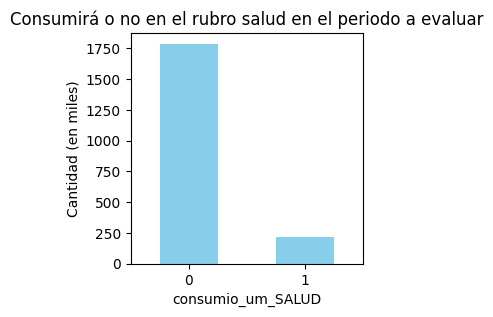

In [11]:
#-------- IDENTIFICAR SI SE REQUIERE O NO DE BALANCEO DE DATOS

conteo=df_sql_resultados['consumio_um_SALUD'].value_counts()/1000

plt.figure(figsize=(3,3))
conteo.plot(kind='bar',color='skyblue')
plt.title('Consumirá o no en el rubro salud en el periodo a evaluar')
plt.xlabel('consumio_um_SALUD')
plt.ylabel('Cantidad (en miles)')
plt.xticks(rotation=0)
plt.show()

In [12]:
#BALANCEO DE DATOS

sm = SMOTE(random_state=42)

#=============  SALUD ===============================
x_flg_salud_train, y_flg_salud_train = sm.fit_resample(x_flg_salud_train, y_flg_salud_train)



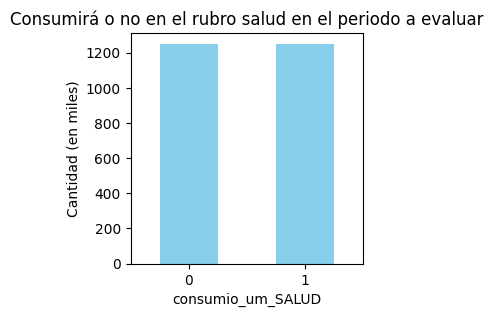

In [13]:
conteo=y_flg_salud_train.value_counts()/1000

plt.figure(figsize=(3,3))
conteo.plot(kind='bar',color='skyblue')
plt.title('Consumirá o no en el rubro salud en el periodo a evaluar')
plt.xlabel('consumio_um_SALUD')
plt.ylabel('Cantidad (en miles)')
plt.xticks(rotation=0)
plt.show()

In [ ]:
from sklearn.metrics import precision_score,recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

#MODELO RANDOMFOREST 

ML_randomforest = RandomForestClassifier(n_estimators=200, max_depth= 10,min_samples_split=5,min_samples_leaf= 2,max_features='sqrt',random_state=0)
ML_randomforest.fit(x_flg_salud_train, y_flg_salud_train)
y_flg_salud_PREDICT_random_forest = ML_randomforest.predict(x_flg_salud_test)

#MODELO GRADIENT BOOSTING 

ML_g_boosting = GradientBoostingClassifier(n_estimators=200, max_depth= 10,min_samples_split=5,min_samples_leaf= 2,max_features='sqrt',random_state=0)
ML_g_boosting.fit(x_flg_salud_train, y_flg_salud_train)
y_flg_salud_PREDICT_g_boosting = ML_g_boosting.predict(x_flg_salud_test)

#ARBOL DE DECISION 

ML_treeClassifier = DecisionTreeClassifier( max_depth= 10,min_samples_split=5,min_samples_leaf= 2,max_features='sqrt',random_state=0)
ML_treeClassifier.fit(x_flg_salud_train, y_flg_salud_train)
y_flg_salud_PREDICT_treeClassifier = ML_treeClassifier.predict(x_flg_salud_test)

#NAIVE BAYES

ML_naive_bayes = GaussianNB()
ML_naive_bayes.fit(x_flg_salud_train, y_flg_salud_train)
y_flg_salud_PREDICT_naive_bayes = ML_naive_bayes.predict(x_flg_salud_test)

#REGRESION LOGISTICA 

ML_regresion_logistica = LogisticRegression(random_state=0)
ML_regresion_logistica.fit(x_flg_salud_train, y_flg_salud_train)
y_flg_salud_PREDICT_regresion_logistica = ML_regresion_logistica.predict(x_flg_salud_test)

#MODELO KNN 

ML_knn = KNeighborsClassifier(n_neighbors=5)
ML_knn.fit(x_flg_salud_train, y_flg_salud_train)
y_flg_salud_PREDICT_KNN = ML_knn.predict(x_flg_salud_test)


In [ ]:
#GUARDAMOS MODELOS
"""
joblib.dump(ML_randomforest,'C:/Users/xvillanuevam/Desktop/TRASPASO PRACTICANTE/QUERYS VARIOS/ML/MODELOS ENTRENADOS/ML_randomforest.pkl')
joblib.dump(ML_g_boosting, 'C:/Users/xvillanuevam/Desktop/TRASPASO PRACTICANTE/QUERYS VARIOS/ML/MODELOS ENTRENADOS/ML_g_boosting.pkl')
joblib.dump(ML_treeClassifier,'C:/Users/xvillanuevam/Desktop/TRASPASO PRACTICANTE/QUERYS VARIOS/ML/MODELOS ENTRENADOS/ML_treeClassifier.pkl')
joblib.dump(ML_naive_bayes, 'C:/Users/xvillanuevam/Desktop/TRASPASO PRACTICANTE/QUERYS VARIOS/ML/MODELOS ENTRENADOS/ML_naive_bayes.pkl')
joblib.dump(ML_regresion_logistica, 'C:/Users/xvillanuevam/Desktop/TRASPASO PRACTICANTE/QUERYS VARIOS/ML/MODELOS ENTRENADOS/ML_regresion_logistica.pkl')
joblib.dump(ML_knn, 'C:/Users/xvillanuevam/Desktop/TRASPASO PRACTICANTE/QUERYS VARIOS/ML/MODELOS ENTRENADOS/ML_knn.pkl')
"""

['C:/Users/xvillanuevam/Desktop/TRASPASO PRACTICANTE/QUERYS VARIOS/ML/MODELOS ENTRENADOS/ML_knn.pkl']

In [14]:
#Se carga modelos

ML_randomforest=joblib.load('C:/Users/xvillanuevam/Desktop/TRASPASO PRACTICANTE/QUERYS VARIOS/ML/MODELOS ENTRENADOS/ML_randomforest.pkl')
ML_g_boosting=joblib.load('C:/Users/xvillanuevam/Desktop/TRASPASO PRACTICANTE/QUERYS VARIOS/ML/MODELOS ENTRENADOS/ML_g_boosting.pkl')
ML_treeClassifier=joblib.load('C:/Users/xvillanuevam/Desktop/TRASPASO PRACTICANTE/QUERYS VARIOS/ML/MODELOS ENTRENADOS/ML_treeClassifier.pkl')
ML_naive_bayes=joblib.load( 'C:/Users/xvillanuevam/Desktop/TRASPASO PRACTICANTE/QUERYS VARIOS/ML/MODELOS ENTRENADOS/ML_naive_bayes.pkl')
ML_regresion_logistica=joblib.load('C:/Users/xvillanuevam/Desktop/TRASPASO PRACTICANTE/QUERYS VARIOS/ML/MODELOS ENTRENADOS/ML_regresion_logistica.pkl')
ML_knn=joblib.load('C:/Users/xvillanuevam/Desktop/TRASPASO PRACTICANTE/QUERYS VARIOS/ML/MODELOS ENTRENADOS/ML_knn.pkl')



In [30]:
def metricas(models,x_flg_salud_test,y_flg_salud_test): # precision, sensibilidad, especificidad, F1
    
    # Almacenar las métricas
    results = []
 
    for name, model in models.items():
        # Predicciones
        y_pred = model.predict(x_flg_salud_test)

        # Calcular métrica
        calculo_exactitud = accuracy_score(y_flg_salud_test, y_pred)
        
        calculo_precision = precision_score(y_flg_salud_test, y_pred)

        calculo_sensibilidad = recall_score(y_flg_salud_test, y_pred)

        vn,fp,fn,vp=confusion_matrix(y_flg_salud_test,y_pred).ravel()
        calculo_especificidad = vn/(vn+fp)

        calculo_f1 = f1_score(y_flg_salud_test, y_pred)

        #Se guarda resultados
        results.append([name,calculo_exactitud,calculo_precision,calculo_sensibilidad,calculo_especificidad,calculo_f1])
    
    metrics_df = pd.DataFrame(results, columns=["Modelo","Exactitud","Precision","Sensibilidad","Especificidad","F1 - score"])
    return metrics_df

In [31]:

# Definir los modelos
models = {
    "Random Forest": ML_randomforest,
    "Gradient Boosting": ML_g_boosting,
    "Tree Classifier": ML_treeClassifier,
    "Naive Bayes":ML_naive_bayes,
    "Regresión logística":ML_regresion_logistica,
}
 
result_metricas=metricas(models,x_flg_salud_test,y_flg_salud_test)

In [32]:
#EXACTITUD
print(result_metricas[["Modelo","Exactitud"]].to_string(index=False))

             Modelo  Exactitud
      Random Forest   0.923566
  Gradient Boosting   0.942029
    Tree Classifier   0.909073
        Naive Bayes   0.846714
Regresión logística   0.922766


In [34]:
#PRECISION
print(result_metricas[["Modelo","Precision"]].to_string(index=False))

             Modelo  Precision
      Random Forest   0.583333
  Gradient Boosting   0.663160
    Tree Classifier   0.541824
        Naive Bayes   0.408554
Regresión logística   0.581689


In [ ]:
#SENSIBILIDAD
print(result_metricas[["Modelo","Sensibilidad"]].to_string(index=False))

             Modelo  Sensibilidad
      Random Forest      0.998553
  Gradient Boosting      0.930640
    Tree Classifier      0.970205
        Naive Bayes      0.967949
Regresión logística      0.989125


In [27]:
#ESPECIFICIDAD
print(result_metricas[["Modelo","Especificidad"]].to_string(index=False))

             Modelo  Especificidad
      Random Forest       0.914586
  Gradient Boosting       0.943393
    Tree Classifier       0.901753
        Naive Bayes       0.832196
Regresión logística       0.914819


In [28]:
#F1
print(result_metricas[["Modelo","F1 - score"]].to_string(index=False))

             Modelo  F1 - score
      Random Forest    0.736448
  Gradient Boosting    0.774455
    Tree Classifier    0.695331
        Naive Bayes    0.574586
Regresión logística    0.732567


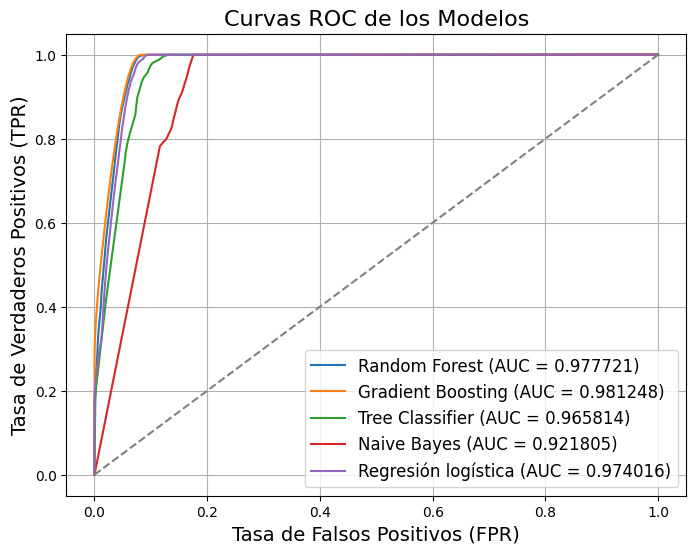

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
 
 # Definir los modelos
models = {
    "Random Forest": ML_randomforest,
    "Gradient Boosting": ML_g_boosting,
    "Tree Classifier": ML_treeClassifier,
    "Naive Bayes":ML_naive_bayes,
    "Regresión logística":ML_regresion_logistica,
}
# Preparar la gráfica
plt.figure(figsize=(8, 6))
# Entrenar modelos y calcular curvas ROC
for name, model in models.items():
    # Obtener las probabilidades de predicción
    y_proba = model.predict_proba(x_flg_salud_test)[:, 1]
    # Calcular la curva ROC
    fpr, tpr, _ = roc_curve(y_flg_salud_test, y_proba)
    roc_auc = auc(fpr, tpr)
    # Dibujar la curva
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.6f})")
 
# Configurar la gráfica
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Línea base
plt.title("Curvas ROC de los Modelos", fontsize=16)
plt.xlabel("Tasa de Falsos Positivos (FPR)", fontsize=14)
plt.ylabel("Tasa de Verdaderos Positivos (TPR)", fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid()
plt.show()

In [62]:
# Aplicación de validación cruzada para la evaluación del modelo
from sklearn.model_selection import cross_val_score

scores=cross_val_score(rfc_supermaket,x1,y1,cv=3,scoring='accuracy')

print(f"scores por fold: {scores}")
print(f"accuracy promedio: {scores.mean()}")

scores por fold: [0.83639306 0.83823221 0.83721343]
accuracy promedio: 0.837279568509532
